# Mohit Yadav
## CSCI 5541 HW1

Loading the data.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sentencepiece as spm

In [2]:
## Set device to Cude if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from torchtext.datasets import IMDB #type: ignore

train_iter, text_iter = IMDB(split=('train', 'test'))

## See sample of data.
for label, text in train_iter:
    print(f"Text with label={label}: {text}")
    break

/Users/saturn/miniforge3/envs/nlp/lib/python3.12/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/saturn/miniforge3/envs/nlp/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/saturn/miniforge3/envs/nlp/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: U

Text with label=1: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We see a lot of html in the text, and there are symbols which don't have meaning for our work. So we will need to clean the data before using.

## Text Cleaning and Tokenization.

In [4]:
## Convert the data to a pandas df for easy processing.
train_df = pd.DataFrame(train_iter, columns=['label', 'text'])
test_df = pd.DataFrame(text_iter, columns=['label', 'text'])
train_df.head()

,label,text
0,1,I rented I AM CURIOUS-YELLOW from my video sto...
1,1,"""I Am Curious: Yellow"" is a risible and preten..."
2,1,If only to avoid making this type of film in t...
3,1,This film was probably inspired by Godard's Ma...
4,1,"Oh, brother...after hearing about this ridicul..."


In [5]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_17690/256755324.py:6: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_17690/256755324.py:7: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_17690/256755324.py:11: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [6]:
## Clean the text and store in a txt file.
with open("cleaned_text.txt", "w") as f:
    for label, text in train_iter:
        f.write(clean_text(text).strip() + "\n")

In [7]:
### BPE Tokenization.
## Create spm model with our data and vocab size of 10000.
VOCAB_SIZE = 10000
spm.SentencePieceTrainer.train(input='./cleaned_text.txt', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

## Tokenization functions.
def tokenize_into_str(text):
    return " ".join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
    return " ".join([str(tok) for tok in sp.encode(text)])

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./cleaned_text.txt
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [8]:
## Add cleaned text to train_df.
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['tokenized_text'] = train_df['cleaned_text'].apply(tokenize_into_str)
train_df['tokenized_idx'] = train_df['cleaned_text'].apply(tokenize_into_idx)

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['tokenized_text'] = test_df['cleaned_text'].apply(tokenize_into_str)
test_df['tokenized_idx'] = test_df['cleaned_text'].apply(tokenize_into_idx)

LOG(INFO) Added: freq=113 size=6960 all=159326 active=8296 piece=▁infer
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=113 size=6980 all=159383 active=8353 piece=▁generous
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=112 size=7000 all=159599 active=8569 piece=▁hank
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=112 min_freq=36
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=112 size=7020 all=159663 active=8038 piece=▁menacing
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=111 size=7040 all=159830 active=8205 piece=▁mast
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=111 size=7060 all=159927 active=8302 piece=▁luckily
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=110 size=7080 all=160031 active=8406 piece=▁rein
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=109 size=7100 all=160113 active=8488 piece=ideo
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=109 min_freq=36
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=109 size=7120 all=1

In [9]:
## Clean the dataframe for idx and nan values.
train_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
train_df.dropna(subset=['tokenized_idx'], inplace=True)

test_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
test_df.dropna(subset=['tokenized_idx'], inplace=True)

In [10]:
## Add the size of tokens to df.
def count_tokens(text):
    return len(text.split())

train_df['num_tokens'] = train_df['tokenized_idx'].apply(count_tokens)
test_df['num_tokens'] = test_df['tokenized_idx'].apply(count_tokens)

In [11]:
train_df.head() 

,label,text,cleaned_text,tokenized_text,tokenized_idx,num_tokens
0,1,I rented I AM CURIOUS-YELLOW from my video sto...,i rented i am curiousyellow from my video stor...,▁i ▁rented ▁i ▁am ▁curious ye llow ▁from ▁my ▁...,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...,311
1,1,"""I Am Curious: Yellow"" is a risible and preten...",i am curious yellow is a risible and pretentio...,▁i ▁am ▁curious ▁yellow ▁is ▁a ▁ris ible ▁and ...,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...,258
2,1,If only to avoid making this type of film in t...,if only to avoid making this type of film in t...,▁if ▁only ▁to ▁avoid ▁making ▁this ▁type ▁of ▁...,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...,100
3,1,This film was probably inspired by Godard's Ma...,this film was probably inspired by godards mas...,▁this ▁film ▁was ▁probably ▁inspired ▁by ▁god ...,62 89 78 815 3746 163 1271 1459 14 2034 128 11...,131
4,1,"Oh, brother...after hearing about this ridicul...",oh brotherafter hearing about this ridiculous ...,▁oh ▁brother after ▁hearing ▁about ▁this ▁ridi...,1388 1693 4148 4685 198 62 1663 89 85 6916 219...,370


In [12]:
## Stats of number of tokens in data.
print(f"Train:\t mean={train_df['num_tokens'].mean():.2f}, std={train_df['num_tokens'].std():.2f}, max={train_df['num_tokens'].max():.2f}, min={train_df['num_tokens'].min():.2f}")
print(f"Test:\t mean={test_df['num_tokens'].mean():.2f}, std={test_df['num_tokens'].std():.2f}, max={test_df['num_tokens'].max():.2f}, min={test_df['num_tokens'].min():.2f}")

Train:	 mean=261.99, std=201.15, max=3190.00, min=10.00
Test:	 mean=257.09, std=196.28, max=2612.00, min=6.00


There is a lot of variation in token size as seen from the high std values.

In [13]:
## Split the data into train and test sets.
X = train_df[['tokenized_idx', 'num_tokens']]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)


In [14]:
train_data.head()

,tokenized_idx,num_tokens,label
6920,217 369 190 2879 62 100 604 78 7 2154 2144 999...,137,1
17926,40 1740 1980 178 911 32 3650 62 89 4635 6622 4...,68,2
1123,62 990 472 130 2906 105 64 4357 1540 245 53 25...,389,1
4518,6 646 878 64 7 1574 33 6467 9985 58 42 134 652...,173,1
5576,62 42 7 814 100 6 130 454 421 7 9137 4011 3785...,138,1


In [15]:
test_df = test_df[['tokenized_idx', 'num_tokens', 'label']]
test_df

,tokenized_idx,num_tokens,label
0,6 418 2507 30 260 3706 32 758 240 94 4 536 250...,266,1
1,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...,230,1
2,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...,141,1
3,787 1707 4819 813 5125 813 5125 4236 5471 813 ...,410,1
4,352 374 767 190 445 214 95 2020 1467 4 2043 97...,137,1
...,...,...,...
24995,188 615 689 32 1030 2438 216 7668 46 268 342 4...,807,2
24996,6 615 62 82 370 33 4 6879 8852 6 945 46 109 26...,136,2
24997,6 615 2438 216 40 4 1931 590 33 1021 382 446 6...,231,2
24998,2007 780 40 6 1814 32 508 257 3222 205 62 78 9...,398,2


In [16]:
## DataLoader Class
class imdbDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text_indices = [int(token_idx) for token_idx in self.dataset.iloc[idx]['tokenized_idx'].split()]
        number_of_tokens = self.dataset.iloc[idx]['num_tokens']
        if 'label' in self.dataset.columns:
            label = self.dataset.iloc[idx]['label'] - 1 
        else:
            label = None
        return text_indices, number_of_tokens, label

In [17]:
## Define hyperparameters
BATCH_SIZE = 32
EMBED_DIM = 32
NUM_CLASS = 2

## Set Seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [18]:
class SLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        return self.fc(self.embedding_sum(text, offsets))

In [19]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        return self.fc2(self.fc1(self.embedding_sum(text, offsets)))

In [20]:
def generate_batch(batch):
    batch_indices = []
    batch_labels = []
    offsets = [0]

    for text_indices, number_of_tokens, label in batch:
        batch_indices.extend(text_indices)
        batch_labels.append(label)
        offsets.append(number_of_tokens)

    batch_indices = torch.tensor(batch_indices, dtype=torch.long)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return batch_indices, batch_labels, offsets

In [21]:
## Define DataLoaders.
train_loader = DataLoader(imdbDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(imdbDataset(val_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(imdbDataset(test_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

In [22]:
## Define Model
modelSLP = SLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS)

In [23]:
## Define Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelSLP.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [24]:
def train_func(train_loader):
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text_indices, label, number_of_tokens) in enumerate(train_loader):
        total_size += len(label)
        optimizer.zero_grad()
        text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

        # Forward pass.
        model_output = modelSLP(text_indices, number_of_tokens)

        ## Compute loss and accuracy.
        loss = criterion(model_output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (model_output.argmax(dim=1) == label).sum().item()
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def val_func(val_loader):
    val_loss = 0
    val_acc = 0
    total_size = 0
    with torch.no_grad():
        for i, (text_indices, label, number_of_tokens) in enumerate(val_loader):
            total_size += len(label)
            text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

            # Forward pass.
            model_output = modelSLP(text_indices, number_of_tokens)

            ## Compute loss and accuracy.
            loss = criterion(model_output, label)
            val_loss += loss.item()
            val_acc += (model_output.argmax(dim=1) == label).sum().item()
    return val_loss / total_size, val_acc / total_size

def test_func(test_loader):
    test_loss = 0
    test_acc = 0
    total_size = 0
    with torch.no_grad():
        for i, (text_indices, label, number_of_tokens) in enumerate(test_loader):
            total_size += len(label)
            text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

            # Forward pass.
            model_output = modelSLP(text_indices, number_of_tokens)

            ## Compute loss and accuracy.
            loss = criterion(model_output, label)
            test_loss += loss.item()
            test_acc += (model_output.argmax(dim=1) == label).sum().item()
    return test_loss / total_size, test_acc / total_size


In [25]:
### Training Loop

N_EPOCHS = 25

loss = []
accuracy = []
val_accuracy = []
test_accuracy = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader)
    val_loss, val_acc = val_func(val_loader)
    test_loss, test_acc = test_func(test_loader)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {val_acc*100:.2f} | Test. Acc: {test_acc*100:.2f}%')


    loss.append(train_loss)
    accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    test_accuracy.append(test_acc)

Epoch 1 	Train Loss: 0.021 | Train Acc: 58.38% | Val. Acc: 58.03 | Test. Acc: 58.37%
Epoch 2 	Train Loss: 0.018 | Train Acc: 71.42% | Val. Acc: 75.87 | Test. Acc: 75.32%
Epoch 3 	Train Loss: 0.015 | Train Acc: 77.49% | Val. Acc: 79.94 | Test. Acc: 79.46%
Epoch 4 	Train Loss: 0.014 | Train Acc: 81.19% | Val. Acc: 81.38 | Test. Acc: 81.28%
Epoch 5 	Train Loss: 0.012 | Train Acc: 83.14% | Val. Acc: 82.72 | Test. Acc: 82.78%
Epoch 6 	Train Loss: 0.012 | Train Acc: 84.44% | Val. Acc: 82.56 | Test. Acc: 83.04%
Epoch 7 	Train Loss: 0.011 | Train Acc: 85.59% | Val. Acc: 84.34 | Test. Acc: 84.30%
Epoch 8 	Train Loss: 0.011 | Train Acc: 86.31% | Val. Acc: 84.74 | Test. Acc: 84.90%
Epoch 9 	Train Loss: 0.010 | Train Acc: 86.91% | Val. Acc: 84.90 | Test. Acc: 85.14%
Epoch 10 	Train Loss: 0.010 | Train Acc: 87.66% | Val. Acc: 84.21 | Test. Acc: 83.96%
Epoch 11 	Train Loss: 0.010 | Train Acc: 88.04% | Val. Acc: 85.60 | Test. Acc: 85.77%
Epoch 12 	Train Loss: 0.009 | Train Acc: 88.35% | Val. Acc: 85.

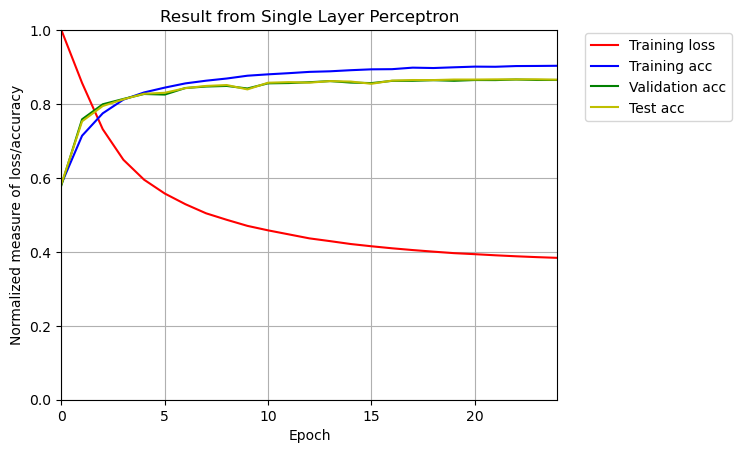

In [26]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracy)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from Single Layer Perceptron")
loss = np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r', label='Training loss')
plt.plot(x_len, accuracy, 'b', label='Training acc')
plt.plot(x_len, val_accuracy, 'g', label='Validation acc')
plt.plot(x_len, test_accuracy, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()


# Multi-Layer Perceptron

In [27]:
HIDDEN_SIZE = 100
modelMLP = MLP(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASS).to(device)

In [28]:
## Define Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [29]:
def train_func(train_loader):
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text_indices, label, number_of_tokens) in enumerate(train_loader):
        total_size += len(label)
        optimizer.zero_grad()
        text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

        # Forward pass.
        model_output = modelMLP(text_indices, number_of_tokens)

        ## Compute loss and accuracy.
        loss = criterion(model_output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (model_output.argmax(dim=1) == label).sum().item()
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def val_func(val_loader):
    val_loss = 0
    val_acc = 0
    total_size = 0
    with torch.no_grad():
        for i, (text_indices, label, number_of_tokens) in enumerate(val_loader):
            total_size += len(label)
            text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

            # Forward pass.
            model_output = modelMLP(text_indices, number_of_tokens)

            ## Compute loss and accuracy.
            loss = criterion(model_output, label)
            val_loss += loss.item()
            val_acc += (model_output.argmax(dim=1) == label).sum().item()
    return val_loss / total_size, val_acc / total_size

def test_func(test_loader):
    test_loss = 0
    test_acc = 0
    total_size = 0
    with torch.no_grad():
        for i, (text_indices, label, number_of_tokens) in enumerate(test_loader):
            total_size += len(label)
            text_indices, number_of_tokens, label = text_indices.to(device), number_of_tokens.to(device), label.to(device)

            # Forward pass.
            model_output = modelMLP(text_indices, number_of_tokens)

            ## Compute loss and accuracy.
            loss = criterion(model_output, label)
            test_loss += loss.item()
            test_acc += (model_output.argmax(dim=1) == label).sum().item()
    return test_loss / total_size, test_acc / total_size


In [30]:
### Training Loop

N_EPOCHS = 26

loss = []
accuracy = []
val_accuracy = []
test_accuracy = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader)
    val_loss, val_acc = val_func(val_loader)
    test_loss, test_acc = test_func(test_loader)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Acc: {val_acc*100:.2f} | Test. Acc: {test_acc*100:.2f}%')


    loss.append(train_loss)
    accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    test_accuracy.append(test_acc)
    

Epoch 1 	Train Loss: 0.021 | Train Acc: 59.89% | Val. Acc: 65.63 | Test. Acc: 66.01%
Epoch 2 	Train Loss: 0.017 | Train Acc: 72.75% | Val. Acc: 64.66 | Test. Acc: 64.39%
Epoch 3 	Train Loss: 0.014 | Train Acc: 78.66% | Val. Acc: 65.55 | Test. Acc: 65.35%
Epoch 4 	Train Loss: 0.013 | Train Acc: 82.15% | Val. Acc: 83.97 | Test. Acc: 84.38%
Epoch 5 	Train Loss: 0.011 | Train Acc: 83.98% | Val. Acc: 83.47 | Test. Acc: 83.82%
Epoch 6 	Train Loss: 0.010 | Train Acc: 85.59% | Val. Acc: 80.34 | Test. Acc: 80.24%
Epoch 7 	Train Loss: 0.010 | Train Acc: 86.95% | Val. Acc: 82.83 | Test. Acc: 82.48%
Epoch 8 	Train Loss: 0.009 | Train Acc: 87.74% | Val. Acc: 79.60 | Test. Acc: 79.60%
Epoch 9 	Train Loss: 0.009 | Train Acc: 88.43% | Val. Acc: 86.18 | Test. Acc: 86.43%
Epoch 10 	Train Loss: 0.008 | Train Acc: 89.02% | Val. Acc: 86.13 | Test. Acc: 86.10%
Epoch 11 	Train Loss: 0.008 | Train Acc: 89.39% | Val. Acc: 86.66 | Test. Acc: 86.57%
Epoch 12 	Train Loss: 0.008 | Train Acc: 90.10% | Val. Acc: 86.

TypeError: can only concatenate list (not "int") to list

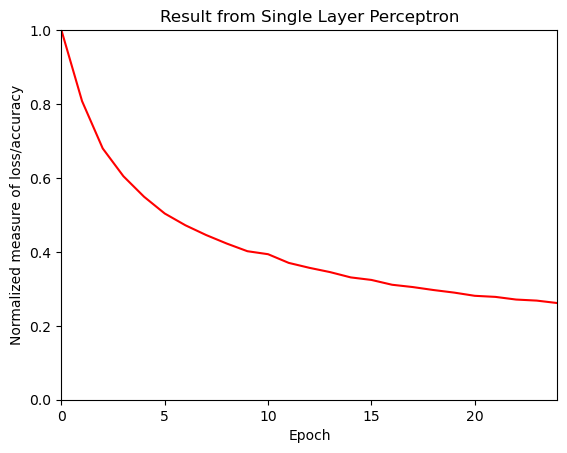

In [36]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracy)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from Single Layer Perceptron")
loss = np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r', label='Training loss')
plt.plot(x_len, accuracy, 'b', label='Training acc')
plt.plot(x_len, val_accuracy, 'g', label='Validation acc')
plt.plot(x_len, test_accuracy, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()
